# 随便写写策略-1

- **时间**：2025/10/12
- **框架**：backtrader
- **简介**：今天是第一次尝试写策略。尝试写一个简单的策略，并使用backtrader的回测功能进行测试。

In [1]:
import tushare as ts, pandas as pd, backtrader as bt
from datetime import datetime

import matplotlib.pyplot as plt

my_token = '251624ebd8ce6534da92c287e3db586b7c54ec71b92cd34468a81042'

## 数据

In [2]:
ts.set_token(my_token)
pro = ts.pro_api()

def get_ts_daily(code, start='20150101', end='20241231'):
    """拉取 TuShare 前复权日线，直接返回 Backtrader 可用的 DataFrame"""
    df = pro.daily(ts_code=code, start_date=start, end_date=end,
                   fields='trade_date,open,high,low,close,vol')
    df = df.sort_values('trade_date')
    df['trade_date'] = pd.to_datetime(df['trade_date'])
    df.rename(columns={'trade_date':'datetime','vol':'volume'}, inplace=True)
    df.set_index('datetime', inplace=True)
    df['openinterest'] = 0          # Backtrader 强制字段
    return df

示例：平安银行 000001.SZ

In [3]:
df = get_ts_daily('000001.SZ')
df.head()

,open,high,low,close,volume,openinterest
datetime,,,,,,
2015-01-05,15.99,16.28,15.60,16.02,2860436.43,0
2015-01-06,15.85,16.39,15.55,15.78,2166421.40,0
2015-01-07,15.56,15.83,15.30,15.48,1700120.67,0
2015-01-08,15.50,15.57,14.90,14.96,1407714.21,0
2015-01-09,14.90,15.87,14.71,15.08,2508500.23,0


In [7]:
df.tail()

,open,high,low,close,volume,openinterest
datetime,,,,,,
2024-12-25,11.86,12.02,11.84,11.92,1475282.94,0
2024-12-26,11.92,11.93,11.78,11.86,1000074.70,0
2024-12-27,11.87,11.90,11.66,11.83,1290012.28,0
2024-12-30,11.78,11.97,11.78,11.95,1351846.36,0
2024-12-31,11.93,11.99,11.70,11.70,1475367.33,0


<Axes: title={'center': '000001.SZ'}, xlabel='datetime'>

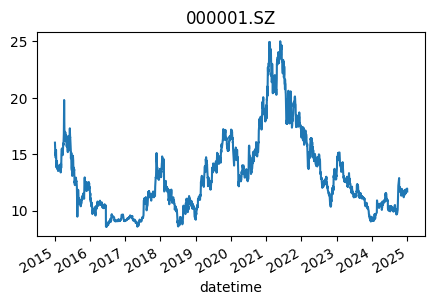

In [6]:
%matplotlib inline
df['close'].plot(figsize=(5,3), title='000001.SZ')

## 策略

最傻的：**双均线**

In [4]:
class SmaCross(bt.SignalStrategy):
    params = dict(fast=5, slow=20)
    def __init__(self):
        # 使用简单移动平均线指标(SMA)计算快线和慢线
        fast = bt.ind.SMA(period=self.p.fast)  # 快线，周期由参数self.p.fast决定
        slow = bt.ind.SMA(period=self.p.slow)  # 慢线，周期由参数self.p.slow决定
        # 金叉做多，死叉平仓
        self.signal_add(bt.SIGNAL_LONG, bt.ind.CrossOver(fast, slow))

## **回测**

选取近来的交易日，回测策略

<Axes: title={'center': '000001.SZ'}, xlabel='datetime'>

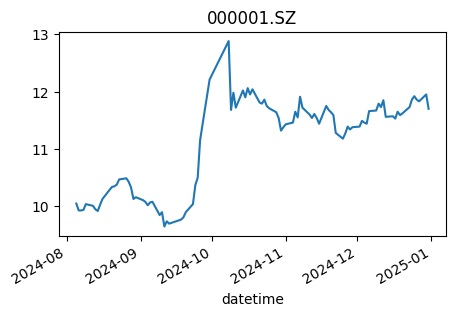

In [5]:
%matplotlib inline
df_= df.iloc[-100:]
df_['close'].plot(figsize=(5,3), title='000001.SZ')

In [6]:
# 创建Cerebro引擎实例
cerebro = bt.Cerebro()
# 将Pandas DataFrame数据转换为Backtrader数据格式并添加到引擎中
data = bt.feeds.PandasData(dataname=df_)
cerebro.adddata(data)
# 添加交易策略SmaCross
cerebro.addstrategy(SmaCross)
# 设置初始资金为100000
cerebro.broker.setcash(100000.)
# 添加仓位管理器，使用95%的仓位进行交易
cerebro.addsizer(bt.sizers.PercentSizer, percents=95)  # 95% 仓位
# 添加收益率分析器，命名为'ret'
cerebro.addanalyzer(bt.analyzers.Returns, _name='ret')
# 添加回撤分析器，命名为'dd'
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='dd')
# 添加夏普比率分析器，命名为'sharp'，设置无风险利率为0.03
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharp', riskfreerate=0.03)

In [7]:
print('初始市值:', cerebro.broker.getvalue())
back = cerebro.run()
print('期末市值:', cerebro.broker.getvalue())

# 打印关键指标
ana = back[0].analyzers
print('年化收益 %.2f%%' % (ana.ret.get_analysis()['rnorm100']))
print('最大回撤 %.2f%%' % (ana.dd.get_analysis()['max']['drawdown']))
print('夏普比率 %.2f' % ana.sharp.get_analysis()['sharperatio'])

初始市值: 100000.0
期末市值: 104952.5999443562
年化收益 12.95%
最大回撤 14.83%


TypeError: must be real number, not NoneType

**数据不足**：计算夏普比率需要足够的历史数据，如果数据点太少，可能无法计算。

<IPython.core.display.Javascript object>

c:\Users\杉嶋桐惠\AppData\Local\Programs\Python\Python310\lib\site-packages\backtrader\plot\locator.py:184: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 14.
  warnings.warn('AutoDateLocator was unable to pick an '


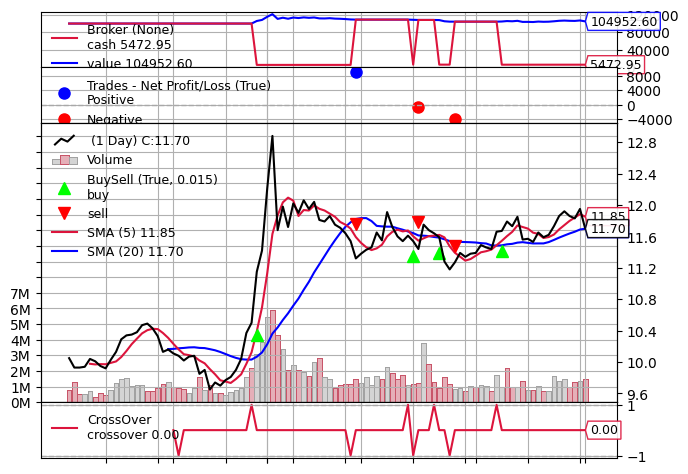

In [18]:
%matplotlib inline
cerebro.plot(style='line', barup='red', bardown='green',
             numfigs=1,      # 强制单图
             dpi=80,         # 分辨率降一点
             tight=True,     # 去掉多余空白
             iplot=True)[0][0]

In [1]:
# %%time

# cerebro.optstrategy(SmaCross, fast=range(3, 21, 5), slow=range(20, 61, 5))
# opt_res = cerebro.run(optreturn=True)   # 返回精简结果

# # 整理成 DataFrame 看夏普
# paras_sharp = [[x[0].params.fast,
#                 x[0].params.slow,
#                 x[0].analyzers.sharp.get_analysis()['sharperatio']]
#                for x in opt_res]
# df_para = pd.DataFrame(paras_sharp, columns=['fast','slow','sharpe'])
# print(df_para.sort_values('sharpe', ascending=False).head(10))